In [784]:
import random
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
from graph import Graph

In [785]:
def generate_cluster(n=100, mu1=0, sigma1=0.5, mu2=0, sigma2=0.5):
    # generate cluster having normal distribution
    return np.array([np.random.normal(mu1, sigma1, n), 
                    np.random.normal(mu2, sigma2, n)])

In [786]:
def dist(p1, p2):
    # Euclidean distance between p1 and p2 points
    return np.sqrt(np.sum((p1-p2)**2))

In [787]:
def get_distances(p, data):
    return np.array([dist(p, dp) for dp in data])

In [788]:
def distance_matrix(data1, data2):
    # data rows are points, data columns are their coordinates
    return {(k1, k2):dist(v1, v2) for k2, v2 in data2.items()
                     for k1, v1 in data1.items()}

In [789]:
def get_center(cluster):
    return np.sum(cluster, axis=0) / len(cluster)

In [790]:
def quality(clusters):
    f0 = 0
    for cluster in clusters:
        for i in range(len(cluster)-1):
            for j in range(i+1, len(cluster)):
                f0 += dist(cluster[i], cluster[j]) / len(cluster)
                
    f1 = 0
    for i in range(len(clusters)-1):
        for j in range(i+1, len(clusters)):
            for point in clusters[i]:
                f1 += np.sum(get_distances(point, clusters[j])) / (sum([len(cluster) for cluster in clusters[j:]]))
    return f0 / f1            

In [791]:
def k_means(data, n_clusters): 
    as_dict = {i:data[i] for i in range(data.shape[0])}
    
    # initial
    distances = dict(sorted(distance_matrix(as_dict, as_dict).items(), 
                            key=lambda x: x[1], reverse=True))
    centers = {}
    cnt = 0
    for key in distances:
        for item in key:
            if item not in centers:
                centers[item] = as_dict[item]
                cnt += 1
                if cnt == n_clusters:
                    break
        if cnt == n_clusters:
            break
    
    # iterations
    centers = np.array([value for value in centers.values()])
    new_centers = centers + 1
    while abs(np.sum(centers - new_centers)) > 0:
        clusters = [np.empty((0,len(center))) for center in centers]
        for point in data:
            index = np.argmin(get_distances(point, centers))
            clusters[index] = np.vstack([clusters[index], point])
        new_centers = np.array([get_center(cluster) for cluster in clusters])
        centers = new_centers[:]
    return clusters

In [792]:
def forel(data, r):
    unprocessed_points = data[:]
    centers = np.empty((0, data.shape[1]))
    while len(unprocessed_points):
        center = random.choice(unprocessed_points)
        old_center = center + 1
        while abs(np.sum(center - old_center)) > 0:
            cluster = np.array([point for point in unprocessed_points if dist(center, point) <= r])
            old_center = center[:]
            center = get_center(cluster)   
        centers = np.vstack([centers, center])
        for point in cluster:
            unprocessed_points = np.delete(unprocessed_points, np.argwhere(unprocessed_points==point), 0)
    
    centers_sup = sup(centers, k=3)
    centers = np.array([get_center(cluster) for cluster in centers_sup])
    
    clusters = [np.empty((0,len(center))) for center in centers]
    for point in data:
        index = np.argmin(get_distances(point, centers))
        clusters[index] = np.vstack([clusters[index], point])
    return clusters

In [793]:
def sup(data, k):
    # data rows are points, data columns are their coordinates
    graph = Graph(data.shape[0], data)
    while graph.isolated():
        if len(graph.edges()) == 0:
            distances = dict(
                sorted(filter(lambda x: x[1] != 0,
                              distance_matrix(graph.isolated_values(),
                                              graph.isolated_values()).items()),
                       key=lambda x: x[1]))
        else:
            point_index = list(graph.edges().items())[-1][0][
                random.choice([0, 1])]
            point = {point_index: graph.vertex_values[point_index]}
            distances = distance_matrix(point,
                                        graph.isolated_values()).items()
            distances = dict(sorted(filter(lambda x: x[1] != 0, distances),
                                    key=lambda x: x[1]))
        min_dist = list(distances.keys())[0]
        graph.add_edge(min_dist[0], min_dist[1])
    edges = dict(
        sorted(graph.edges().items(), key=lambda x: x[1], reverse=True))
    cnt = 0
    while cnt < k and len(graph.edges()):
        keys = [tuple(sorted(key)) for key in edges.keys()]
        keys = list(set([i for i in keys]))
        
        graph.remove_edge(keys[cnt][0], keys[cnt][1])
        cnt += 1
    clusters = []
    for cluster in graph.clusters():
        clusters.append([graph.values()[i] for i in cluster])
    return [np.array(cluster) for cluster in clusters]

Q: 0.17823782200909355


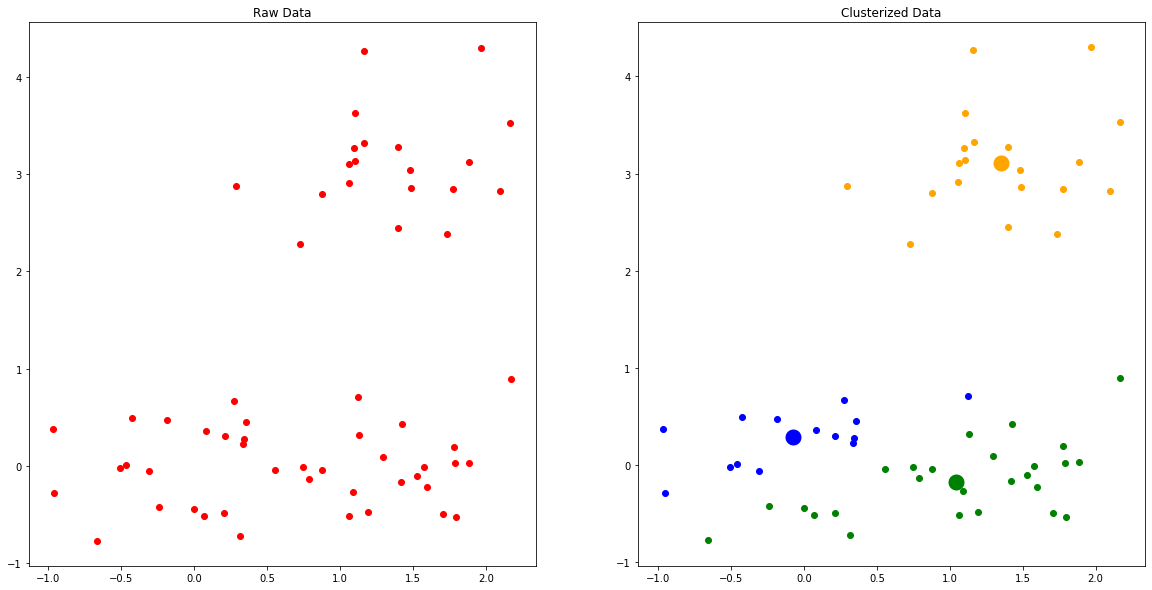

In [794]:
colors = ['orange', 'green', 'blue']
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
cluster = generate_cluster(20)
ax1.scatter(cluster[0], cluster[1], c='red')

cluster1 = generate_cluster(20, mu1=1.5, sigma1=0.5, mu2=0, sigma2=0.5)
ax1.scatter(cluster1[0], cluster1[1], c='red')

cluster2 = generate_cluster(20, mu1=1.5, sigma1=0.5, mu2=3, sigma2=0.5)
ax1.scatter(cluster2[0], cluster2[1], c='red')
ax1.set_title('Raw Data')

data = np.concatenate((cluster.T, cluster1.T, cluster2.T))

clusters = k_means(data, 3)
centers = [get_center(cluster) for cluster in clusters]
alg_quality = quality(clusters)
print(f"Q: {alg_quality}")
for i in range(len(clusters)):
    ax2.scatter(clusters[i].T[0], clusters[i].T[1], c=colors[i])
    ax2.scatter(centers[i][0], centers[i][1], linewidths=10, c=colors[i])
ax2.set_title('Clusterized Data')
plt.show()

Q: 0.49461399112506266


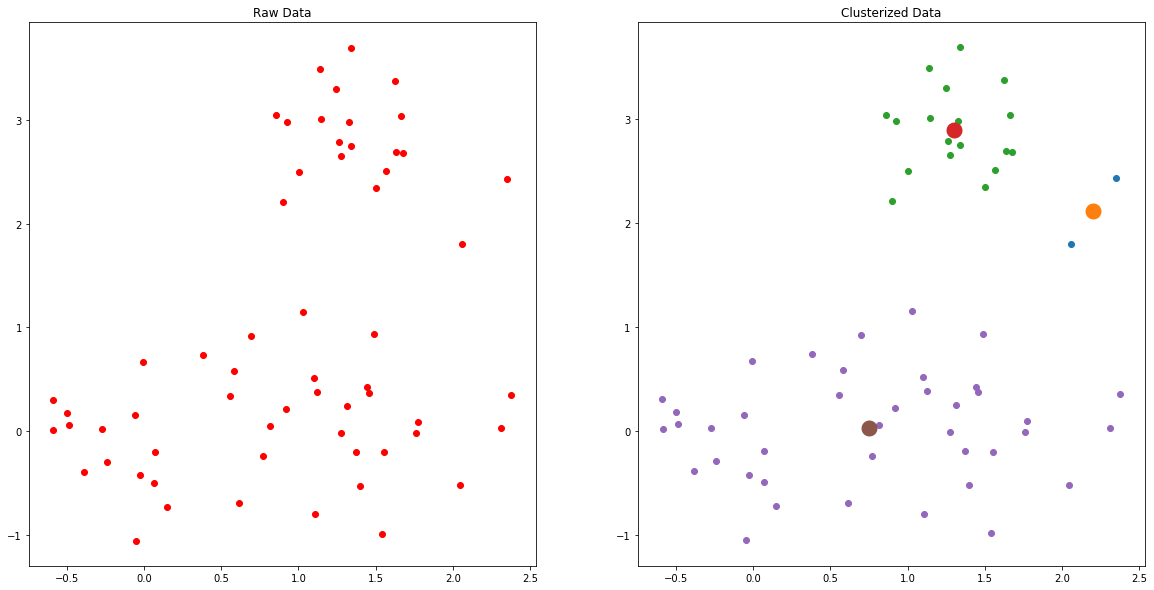

In [795]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
cluster = generate_cluster(20)
ax1.scatter(cluster[0], cluster[1], c='red')

cluster1 = generate_cluster(20, mu1=1.5, sigma1=0.5, mu2=0, sigma2=0.5)
ax1.scatter(cluster1[0], cluster1[1], c='red')

cluster2 = generate_cluster(20, mu1=1.5, sigma1=0.5, mu2=3, sigma2=0.5)
ax1.scatter(cluster2[0], cluster2[1], c='red')
ax1.set_title('Raw Data')

data = np.concatenate((cluster.T, cluster1.T, cluster2.T))

r = 1
clusters = forel(data, r)
centers = [get_center(cluster) for cluster in clusters]
alg_quality = quality(clusters)
print(f"Q: {alg_quality}")
for i in range(len(clusters)):
    ax2.scatter(clusters[i].T[0], clusters[i].T[1])
    ax2.scatter(centers[i][0], centers[i][1], linewidth=10)
ax2.set_title('Clusterized Data')
plt.show()

Q: 0.20240006749772457


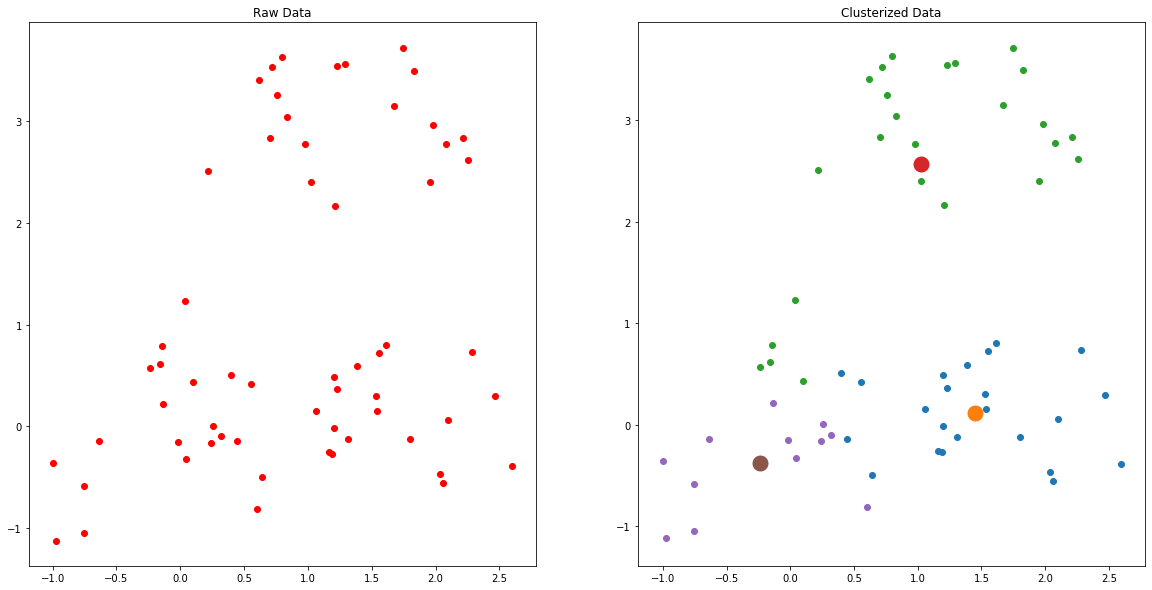

In [822]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
cluster = generate_cluster(20)
ax1.scatter(cluster[0], cluster[1], c='red')

cluster1 = generate_cluster(20, mu1=1.5, sigma1=0.5, mu2=0, sigma2=0.5)
ax1.scatter(cluster1[0], cluster1[1], c='red')

cluster2 = generate_cluster(20, mu1=1.5, sigma1=0.5, mu2=3, sigma2=0.5)
ax1.scatter(cluster2[0], cluster2[1], c='red')
ax1.set_title('Raw Data')

data = np.concatenate((cluster.T, cluster1.T, cluster2.T))

k = 2
clusters = sup(data, k)
centers = [get_center(cluster) for cluster in clusters]
alg_quality = quality(clusters)
print(f"Q: {alg_quality}")
for i in range(len(clusters)):
    ax2.scatter(clusters[i].T[0], clusters[i].T[1])
    ax2.scatter(centers[i][0], centers[i][1], linewidth=10)
ax2.set_title('Clusterized Data')
plt.show()